<a href="https://colab.research.google.com/github/Lalo-Reyes-12/AI-Semantic-Segmentation/blob/Lalo/Unet_Model_Cityscapes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from torchvision.datasets import Cityscapes
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np
import torch
import torch.nn as nn

In [3]:
dataset = Cityscapes('/content/drive/MyDrive/Segformer', split='train', mode='fine',
                      target_type='semantic')

In [4]:
dataset[0][0].size

(2048, 1024)

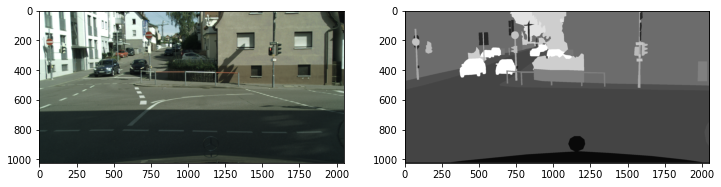

In [5]:
fig,ax=plt.subplots(ncols=2,figsize=(12,8))
ax[0].imshow(dataset[0][0])
ax[1].imshow(dataset[0][1],cmap='gray')

In [6]:
ignore_index=255
void_classes = [0, 1, 2, 3, 4, 5, 6, 9, 10, 14, 15, 16, 18, 29, 30, -1]
valid_classes = [ignore_index,7, 8, 11, 12, 13, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33]
class_names = ['unlabelled', 'road', 'sidewalk', 'building', 'wall', 'fence', 'pole', 'traffic_light', \
               'traffic_sign', 'vegetation', 'terrain', 'sky', 'person', 'rider', 'car', 'truck', 'bus', \
               'train', 'motorcycle', 'bicycle']
#why i choose 20 classes
#https://stackoverflow.com/a/64242989

class_map = dict(zip(valid_classes, range(len(valid_classes))))
n_classes=len(valid_classes)
class_map

{255: 0,
 7: 1,
 8: 2,
 11: 3,
 12: 4,
 13: 5,
 17: 6,
 19: 7,
 20: 8,
 21: 9,
 22: 10,
 23: 11,
 24: 12,
 25: 13,
 26: 14,
 27: 15,
 28: 16,
 31: 17,
 32: 18,
 33: 19}

In [7]:
colors = [   [  0,   0,   0],
        [128, 64, 128],
        [244, 35, 232],
        [70, 70, 70],
        [102, 102, 156],
        [190, 153, 153],
        [153, 153, 153],
        [250, 170, 30],
        [220, 220, 0],
        [107, 142, 35],
        [152, 251, 152],
        [0, 130, 180],
        [220, 20, 60],
        [255, 0, 0],
        [0, 0, 142],
        [0, 0, 70],
        [0, 60, 100],
        [0, 80, 100],
        [0, 0, 230],
        [119, 11, 32],
    ]

label_colours = dict(zip(range(n_classes), colors))

In [8]:
def encode_segmap(mask):
    #remove unwanted classes and recitify the labels of wanted classes
    for _voidc in void_classes:
        mask[mask == _voidc] = ignore_index
    for _validc in valid_classes:
        mask[mask == _validc] = class_map[_validc]
    return mask

In [9]:
def decode_segmap(temp):
    #convert gray scale to color
    temp=temp.numpy()
    r = temp.copy()
    g = temp.copy()
    b = temp.copy()
    for l in range(0, n_classes):
        r[temp == l] = label_colours[l][0]
        g[temp == l] = label_colours[l][1]
        b[temp == l] = label_colours[l][2]

    rgb = np.zeros((temp.shape[0], temp.shape[1], 3))
    rgb[:, :, 0] = r / 255.0
    rgb[:, :, 1] = g / 255.0
    rgb[:, :, 2] = b / 255.0
    return rgb

In [10]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
transform=A.Compose(
[
    A.Resize(256, 512),
    A.HorizontalFlip(),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
]
)

In [11]:
from typing import Any, Callable, Dict, List, Optional, Union, Tuple
from torchvision.datasets import Cityscapes

class MyClass(Cityscapes):
    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        image = Image.open(self.images[index]).convert('RGB')

        targets: Any = []
        for i, t in enumerate(self.target_type):
            if t == 'polygon':
                target = self._load_json(self.targets[index][i])
            else:
                target = Image.open(self.targets[index][i])
            targets.append(target)
        target = tuple(targets) if len(targets) > 1 else targets[0]

        if self.transforms is not None:
            transformed=transform(image=np.array(image), mask=np.array(target))            
        return transformed['image'],transformed['mask']
    #torch.unsqueeze(transformed['mask'],0)
    

In [12]:
dataset=MyClass('/content/drive/MyDrive/Segformer', split='val', mode='fine',
                     target_type='semantic',transforms=transform)
img,seg= dataset[9]
print(img.shape,seg.shape)

torch.Size([3, 256, 512]) torch.Size([256, 512])


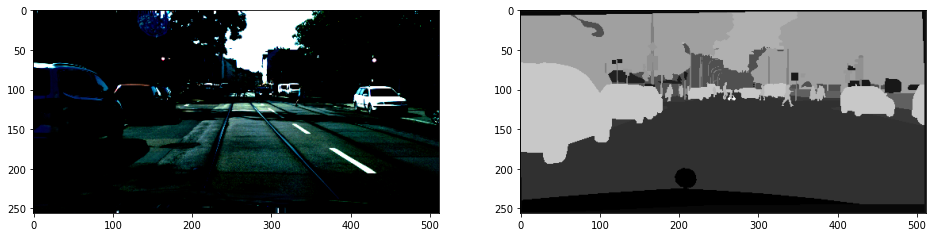

In [13]:
fig,ax=plt.subplots(ncols=2,nrows=1,figsize=(16,8))
ax[0].imshow(img.permute(1, 2, 0))
ax[1].imshow(seg,cmap='gray')

In [14]:
#class labels before label correction
print(torch.unique(seg))
print(len(torch.unique(seg)))

tensor([ 1,  2,  3,  4,  5,  7,  8, 11, 13, 17, 19, 20, 21, 22, 23, 24, 25, 26,
        33], dtype=torch.uint8)
19


In [15]:
#class labels after label correction
res=encode_segmap(seg.clone())
print(res.shape)
print(torch.unique(res))
print(len(torch.unique(res)))

torch.Size([256, 512])
tensor([ 0,  1,  2,  3,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 19],
       dtype=torch.uint8)
15


In [16]:
#let do coloring
res1=decode_segmap(res.clone())

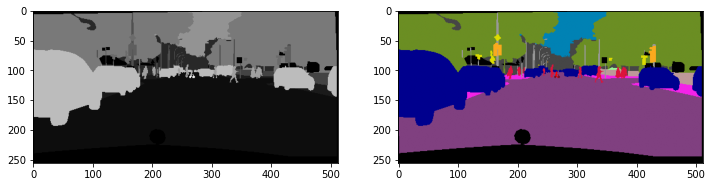

In [17]:
fig,ax=plt.subplots(ncols=2,figsize=(12,10))  
ax[0].imshow(res,cmap='gray')
ax[1].imshow(res1)

In [18]:
#model=torchvision.models.segmentation.deeplabv3_resnet50(pretrained=True)
#model

In [19]:
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
!pip install pytorch_lightning
from pytorch_lightning.callbacks import EarlyStopping,ModelCheckpoint,LearningRateMonitor
!pip install segmentation_models_pytorch
import segmentation_models_pytorch as smp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [20]:
from pytorch_lightning import seed_everything, LightningModule, Trainer
import multiprocessing
import torchmetrics
import torch
class OurModel(LightningModule):
  def __init__(self):
    super(OurModel,self).__init__()
    #architecute
    self.layer = smp.Unet(
                encoder_name="resnet34",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
                encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
                in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
                classes=n_classes,                      # model output channels (number of classes in your dataset)
            )
  
  #parameters
    self.lr=1e-3
    self.batch_size=32
    self.numworker=multiprocessing.cpu_count()//4

    self.criterion= smp.losses.DiceLoss(mode='multiclass')
    self.metrics = torchmetrics.JaccardIndex(task="multiclass", num_classes=n_classes)
    
    self.train_class = MyClass('/content/drive/MyDrive/Segformer', split='train', mode='fine',
                     target_type='semantic',transforms=transform)
    self.val_class = MyClass('/content/drive/MyDrive/Segformer', split='val', mode='fine',
                     target_type='semantic',transforms=transform)
    
    
  def process(self,image,segment):
    out=self(image)
    segment=encode_segmap(segment)
    loss=self.criterion(out,segment.long())
    iou=self.metrics(out,segment)
    return loss,iou
    
  def forward(self,x):
    return self.layer(x)


  def configure_optimizers(self):
    opt=torch.optim.AdamW(self.parameters(), lr=self.lr)
    return opt

  def train_dataloader(self):
    return DataLoader(self.train_class, batch_size=self.batch_size, 
                      shuffle=True,num_workers=self.numworker,pin_memory=True)

  def training_step(self,batch,batch_idx):
    image,segment=batch
    loss,iou=self.process(image,segment)
    self.log('train_loss', loss,on_step=False, on_epoch=True,prog_bar=True)
    self.log('train_iou', iou,on_step=False, on_epoch=True,prog_bar=True)
    return loss

  def val_dataloader(self):
    return DataLoader(self.val_class, batch_size=self.batch_size, 
                      shuffle=False,num_workers=self.numworker,pin_memory=True)
    
  def validation_step(self,batch,batch_idx):
    image,segment=batch
    loss,iou=self.process(image,segment)
    self.log('val_loss', loss,on_step=False, on_epoch=True,prog_bar=False)
    self.log('val_iou', iou,on_step=False, on_epoch=True,prog_bar=False)
    return loss

In [21]:
model = OurModel()
checkpoint_callback = ModelCheckpoint(monitor='val_loss',dirpath='checkpoints',
                                        filename='file',save_last=True)

In [22]:
trainer = Trainer(max_epochs=200, auto_lr_find=False, auto_scale_batch_size=False,
                  gpus=-1,precision=16,
                  callbacks=[checkpoint_callback],
                 )

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:441: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
  rank_zero_deprecation(
INFO:pytorch_lightning.utilities.rank_zero:Using 16bit native Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [23]:
# trainer.fit(model)
# torch.save(model.state_dict(), 'model.pth')

In [24]:
model.load_state_dict(torch.load('/content/drive/MyDrive/model.pth'))

<All keys matched successfully>

In [25]:
test_class = MyClass('/content/drive/MyDrive/Segformer', split='val', mode='fine',
                     target_type='semantic',transforms=transform)
test_loader=DataLoader(test_class, batch_size=50, 
                      shuffle=False)

In [26]:
model=model.cuda()
model.eval()
with torch.no_grad():
    for batch in test_loader:
        img,seg=batch
        output=model(img.cuda())
        break
print(img.shape,seg.shape,output.shape)    

torch.Size([15, 3, 256, 512]) torch.Size([15, 256, 512]) torch.Size([15, 20, 256, 512])


In [27]:
from torchvision import transforms
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.255]
)

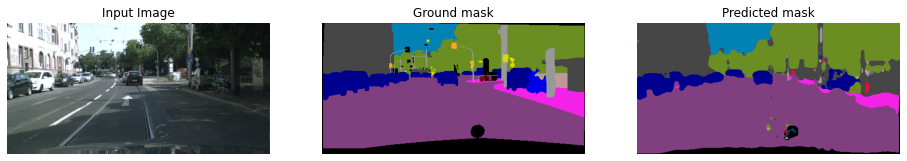

In [28]:
sample=10
invimg=inv_normalize(img[sample])
outputx=output.detach().cpu()[sample]
encoded_mask=encode_segmap(seg[sample].clone()) #(256, 512)
decoded_mask=decode_segmap(encoded_mask.clone())  #(256, 512)
decoded_ouput=decode_segmap(torch.argmax(outputx,0))
fig,ax=plt.subplots(ncols=3,figsize=(16,50),facecolor='white')  
ax[0].imshow(np.moveaxis(invimg.numpy(),0,2)) #(3,256, 512)
#ax[1].imshow(encoded_mask,cmap='gray') #(256, 512)
ax[1].imshow(decoded_mask) #(256, 512, 3)
ax[2].imshow(decoded_ouput) #(256, 512, 3)
ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')
ax[0].set_title('Input Image')
ax[1].set_title('Ground mask')
ax[2].set_title('Predicted mask')
plt.savefig('result.png',bbox_inches='tight')

In [29]:
test_class2 = MyClass('/content/drive/MyDrive/Segformer', split='test', mode='fine',
                     target_type='semantic',transforms=transform)
test_loader2=DataLoader(test_class, batch_size=30, 
                      shuffle=False)

In [50]:
trainer.validate(model=model, dataloaders=test_loader2)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_iou            0.20015260577201843
        val_loss            0.7054031491279602
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'val_loss': 0.7054031491279602, 'val_iou': 0.20015260577201843}]

#Deployment

In [30]:
PATH = '/content/drive/MyDrive/model.pth'
#model.load_state_dict(torch.load(PATH))
model.eval()

OurModel(
  (layer): Unet(
    (encoder): ResNetEncoder(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchN

In [31]:
model.load_state_dict(torch.load(PATH))
model.eval()

OurModel(
  (layer): Unet(
    (encoder): ResNetEncoder(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchN

In [32]:
def transform_image(image_bytes):
    transform = transforms.Compose([transforms.Grayscale(num_output_channels=1),
                                    transforms.Resize((28,28)),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.1307,),(0.3081,))])

    image = Image.open(io.BytesIO(image_bytes))
    return transform(image).unsqueeze(0)

In [33]:
def get_prediction(image_tensor):
    images = image_tensor.reshape(-1, 28*28)
    outputs = model(images)
        # max returns (value ,index)
    _, predicted = torch.max(outputs.data, 1)
    return predicted

In [34]:
from flask import Flask, request, jsonify
!pip install torch_utils
#!pip install transform_image
# !pip install get_prediction
# !apt install transform_image
# !apt install gqt_prediction
# from torch_utils import transform_image, get_prediction

app = Flask(__name__)

ALLOWED_EXTENSIONS = {'png', 'jpg', 'jpeg'}
def allowed_file(filename):
    # xxx.png
    return '.' in filename and filename.rsplit('.', 1)[1].lower() in ALLOWED_EXTENSIONS


@app.route('/predictt', methods=['POST'])
def predict():
    if request.method == 'POST':
        file = request.files.get('file')
        if file is None or file.filename == "":
            return jsonify({'error': 'no file'})
        if not allowed_file(file.filename):
            return jsonify({'error': 'format not supported'})

        try:
            img_bytes = file.read()
            tensor = transform_image(img_bytes)
            prediction = get_prediction(tensor)
            data = {'prediction': prediction.item(), 'class_name': str(prediction.item())}
            return jsonify(data)
        except:
            return jsonify({'error': 'error during prediction'})

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [38]:
!pip install pyngrok --quiet
from pyngrok import ngrok

# Terminate open tunnels if exist
ngrok.kill()

# Setting the authtoken (optional)
# Get your authtoken from https://dashboard.ngrok.com/auth
NGROK_AUTH_TOKEN = "2JxQv3AVFO0dnAfy9AaclFjKRGT_6ttCPAsAWR56CTVzMJJhV"
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

# Open an HTTPs tunnel on port 5000 for http://localhost:5000
public_url = ngrok.connect(port="5000", proto="http", options={"bind_tls": True})
print("Tracking URL:", public_url)

Tracking URL: NgrokTunnel: "http://ab75-34-124-202-8.ngrok.io" -> "http://localhost:80"


In [42]:
import requests 

resp = requests.post('http://ab75-34-124-202-8.ngrok.io/predictt', files={'file': open('/content/drive/MyDrive/berlin_000271_000019_leftImg8bit.png', 'rb')})

print(resp.text)


<!doctype html5>
<html>
    <head>
        <style type="text/css">
         
        strong { font-weight: bold; }
        hr { -moz-box-sizing: content-box; box-sizing: content-box; height: 0; }
        html { font-family: sans-serif;   -ms-text-size-adjust: 100%;   -webkit-text-size-adjust: 100%;   } body { margin: 0; }
        a { background-color: transparent; }
        a:active, a:hover { outline: 0; }
        </style>

        <style type="text/css">
            body { background-color: #f5f5f5; }
            .container { width: 500px; margin: auto; color: #444; padding: 5px; }
            a, strong { color: purple; text-decoration: none; }
            a:hover { text-decoration: underline; }
            h2 { text-align: center; color: #000; }
            p { line-height: 20px; }
        </style>
    </head>
    <body>
        <div class="container">
            
            
<h2>Failed to complete tunnel connection</h2>
<hr />
<p>
    The connection to <strong><a href="http://ab

In [48]:
!pip install gunicorn
#!pip install app.main
!apt app.main

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
E: Invalid operation app.main
